In [1]:
%load_ext autoreload
%autoreload 2

from constructions import *
from plt_utils import *
from geometricMultiGrid1D import *

# 1.2 1D model problem
## (b)

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


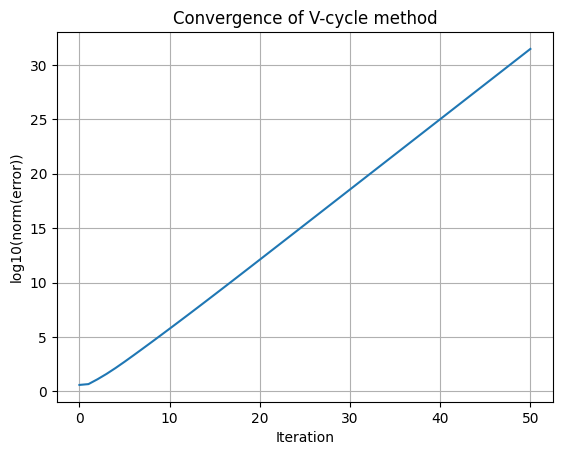

interactive(children=(IntSlider(value=0, description='i', max=50), Output()), _dom_classes=('widget-interact',…

In [2]:
from functools import partial
from scipy.sparse.linalg import spsolve
from scipy.linalg import norm


def helmholtz1D_model(sigma=-600,n=64,recursion_depth=5,iterations =50):
    f = pointsource_half(n)
    u_approx = guessv0(n)
    u_exact = spsolve(helmholtz1D(n,sigma),f)

    errors = [u_exact-u_approx] 
    # Solve using the V-cycle method
    for _ in range(iterations):
        u_approx = geoVcycle1D(
            mat = partial(helmholtz1D,sigma=sigma), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= 2/3), 
            restrict=simple_restrict, 
            interpolate=simple_interpolate, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    norms = np.array([norm(e) for e in errors])
    plt.plot(range(len(norms)),np.log10(norms))
    plt.xlabel("Iteration")
    plt.ylabel("log10(norm(error))")
    plt.grid(True)
    plt.title("Convergence of V-cycle method")
    plt.show()
    plt_vecs(errors,[f"errors after {j} vcycles" for j in range(len(errors))]) 

helmholtz1D_model(sigma=-600,n=64,recursion_depth=5,iterations =50)

# (D)

In [3]:
from ipywidgets import interact,widgets 

@interact(
    n=widgets.IntSlider(min=1, max=200, value=32),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0)
)
def plt_eigen_H(sigma_real,sigma_complex, n):
    sigma = complex(sigma_real,sigma_complex)
    title = rf'eigenvalues of $H$ with $n={n},\sigma = {sigma}$'
    Hs = [helmholtz1D(n*j, sigma) for j in [1,2]]
    labels = [f'$H{j}$' for j in [n,2*n]]
    ys = [eigen_helmhotz1D(n,k,sigma) for k in range(1,n)]
    xs = np.linspace(0,1,len(ys))
    plt.plot(xs,ys,label="formula",linestyle="--")
    plt_eigen(Hs,labels,title)


interactive(children=(FloatSlider(value=0.0, description='sigma_real', max=1000.0, min=-1000.0, step=1.0), Flo…

# 1.3
## (b)

In [8]:
from ipywidgets import interact,widgets 

def G(theta,sigma,omega,n):
    return  1-omega+ 2*(omega * n**2)*np.cos(theta)/(2*n**2+sigma)

@interact(
    n=widgets.IntSlider(min=1, max=100, value=64),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0),
    omega=widgets.FloatSlider(min=-1, max=1, step=0.1, value=2/3)
)
def plt_eigen_Rw_Gtheta(sigma_real,sigma_complex, omega, n):
    sigma = complex(sigma_real,sigma_complex)
    theta = np.linspace(-np.pi, np.pi, n)
    Gs = G(theta, sigma, omega, n)
    Gs_sorted = np.array(sorted(Gs, key=lambda x: np.abs(
        x)*(0 if x.real == 0 else x.real/np.abs(x.real))))
    plt.clf()
    xs = np.linspace(0, 1, len(Gs))
    plt_R_im_abs(xs,Gs,r"$G(\theta)$")
    plt_R_im_abs(xs,Gs_sorted,r"sorted $G(\theta)$","--")
    plt.grid()
    title = rf'$G(\theta)$ and eigenvalues of $R_\omega$ with  $n={n},\sigma = {sigma}, \omega = {omega}$'
    plt_eigen([Romega(n, sigma,omega)],[r"$R_\omega$"],title)



interactive(children=(FloatSlider(value=-600.0, description='sigma_real', max=1000.0, min=-1000.0, step=1.0), …

## (d)

In [44]:
G(0,-600,2/3,64)

1.0526870389884089

# 1.4
## (a)

In [5]:
def s(j,n):return j if j<=n else n-j
n = 2**6
j = 10
plt_vecs([simple_restrict(wave_basis_1D(2*n,j))/(wave_basis_1D(n,s(j,n))+0.00001) for j in range(n)] )

interactive(children=(IntSlider(value=0, description='i', max=63), Output()), _dom_classes=('widget-interact',…

## (b)

In [16]:
@interact(
    n=widgets.IntSlider(min=1,max=1000,step=1,value=64),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0)
)
def plt_rho(n,sigma_real,sigma_complex):
    sigma = complex(sigma_real,sigma_complex)
    ks = np.linspace(1,n,n*10)
    eggs = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
    plt.plot(ks,eggs, label= "1k 10 points")
    ks = np.linspace(1,n,n)
    eggs = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
    plt.plot(ks,eggs, label="1k 1 point")
    plt.legend()
    plt.grid()
    max_index = np.argmax(np.abs(eggs[1:20]))
    print("Index of maximum value in eggs: ", max_index)  
    plt.show()


interactive(children=(IntSlider(value=64, description='n', max=1000, min=1), FloatSlider(value=-600.0, descrip…